In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-dys/anonimyzed_data - Risposte del modulo 1.csv
/kaggle/input/data-dys/italy.csv
/kaggle/input/data-dys/anonimyzed_data - Module 1 answers.csv
/kaggle/input/data-dys/anonimyzed_data - Risp_Pulite.csv
/kaggle/input/data-dys/values.csv


In [2]:
import numpy as np 
import pandas as pd 
import torch.optim as optim
import os
import requests
import zipfile
import torch
import random
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import KFold

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

def read_data():
    df = pd.read_csv('Dataset\values.csv') 
    df = df.stack().rename_axis(('User', 'Item')).reset_index(name='Score')
    item_labels, item_original = pd.factorize(df['Item'])
    df['Item'] = item_labels
    df = df.sample(n=len(df))
    df.replace(' ', 0, inplace=True)
    df.replace('NC', 0, inplace=True)
    df.replace('NSU', 0, inplace=True)
    print(df.isnull().sum())
    df['Score'] = df['Score'].astype(int)
    df = df[df['Score'] != 0]
    num_users = len(df.User.unique())
    num_items = len(df.Item.unique()) 
    return df, num_users, num_items, item_original

cuda


In [4]:
def split_data(data, test_ratio): 
    train_data, test_data = train_test_split(data, test_size=test_ratio, random_state=42)
    return train_data, test_data

In [5]:
def load_data(data, num_users, num_items, feedback='explicit'):
    users, items, scores = [], [], []
    inter = {}
    for line in data.itertuples():
        user_index, item_index = int(line[1]), int(line[2])
        score = int(line[3]) if feedback == 'explicit' else 1
        users.append(user_index)
        items.append(item_index)
        scores.append(score)
        inter.setdefault(user_index, []).append(item_index) 
    return users, items, scores, inter

In [6]:
class PRDataset(Dataset):
    def __init__(self, users, items, candidates, num_items):
        self.users = users
        self.items = items
        self.cand = candidates
        self.all = set([i for i in range(num_items)])

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        neg_items = list(self.all - set(self.cand[int(self.users[idx])]))
        indices = random.randint(0, len(neg_items) - 1)
        return self.users[idx], self.items[idx], neg_items[indices]

In [7]:
class NeuMF(nn.Module):
    def __init__(self, num_factors, num_users, num_items, nums_hiddens):
        super(NeuMF, self).__init__()
        self.P = nn.Embedding(num_users, num_factors)
        self.Q = nn.Embedding(num_items, num_factors)  
        self.U = nn.Embedding(num_users, num_factors)  
        self.V = nn.Embedding(num_items, num_factors)  
        mlp_layers = []
        input_size = num_factors * 2 
        for num_hiddens in nums_hiddens:
            mlp_layers.append(nn.Linear(input_size, num_hiddens))
            mlp_layers.append(nn.ReLU())
            input_size = num_hiddens
        mlp_layers.append(nn.Dropout(0.2))
        self.mlp = nn.Sequential(*mlp_layers)
        self.prediction_layer = nn.Linear(num_factors + nums_hiddens[-1], 1)
        # self.sigmoid = nn.Sigmoid()
        
    def _init_weights(self):
        nn.init.xavier_uniform_(self.P.weight)
        nn.init.xavier_uniform_(self.Q.weight)
        nn.init.xavier_uniform_(self.U.weight)
        nn.init.xavier_uniform_(self.V.weight)
        
        for layer in self.mlp:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)
        nn.init.xavier_uniform_(self.prediction_layer.weight)
        nn.init.zeros_(self.prediction_layer.bias)

    def forward(self, user_id, item_id):
        p_mf = self.P(user_id)
        q_mf = self.Q(item_id)
        gmf = p_mf * q_mf
        p_mlp = self.U(user_id)
        q_mlp = self.V(item_id)
        mlp_input = torch.cat([p_mlp, q_mlp], dim=1)
        mlp_output = self.mlp(mlp_input)
        concat = torch.cat([gmf, mlp_output], dim=1)
        prediction = self.prediction_layer(concat)
        return prediction

In [8]:
def hit_and_auc(rankedlist, test_matrix, k):
    hits_k = [(idx, val) for idx, val in enumerate(rankedlist[:k])
              if val in set(test_matrix)]
    hits_all = [(idx, val) for idx, val in enumerate(rankedlist)
                if val in set(test_matrix)]
    max = len(rankedlist) - 1
    auc = 1.0 * (max - hits_all[0][0]) / max if len(hits_all) > 0 else 0
    return len(hits_k) / k, auc

In [9]:
def evaluate_ranking(net, test_input, seq, candidates, num_users, num_items, device, batch_size, top_k=5):
    ranked_list, ranked_items, hit_rate, auc = {}, {}, [], []
    all_items = set([i for i in range(num_items)])
    for u in range(num_users):
        neg_items = list(all_items - set(candidates[int(u)]))    
        user_ids = [u] * len(neg_items)
        item_ids = neg_items
        x = [torch.tensor(user_ids, device=device), torch.tensor(item_ids, device=device)]
        if seq is not None:
            x.append(seq[user_ids, :].to(device))
        test_data_iter = torch.utils.data.DataLoader(
            dataset=list(zip(*x)), batch_size=batch_size, shuffle=False
        )
        scores = []
        for batch in test_data_iter:
            user_batch, item_batch = batch[0].to(device), batch[1].to(device)
            if seq is not None:
                seq_batch = batch[2].to(device)
                batch_scores = net(user_batch, item_batch, seq_batch).cpu().detach().numpy()
            else:
                batch_scores = net(user_batch, item_batch).cpu().detach().numpy()
            scores.extend(batch_scores)
        item_scores = list(zip(item_ids, scores))
        ranked_list[u] = sorted(item_scores, key=lambda t: t[1], reverse=True)
        ranked_items[u] = [r[0] for r in ranked_list[u]]
        if u not in test_input: 
            continue
        hit, auc_val = hit_and_auc(ranked_items[u], test_input[u], top_k)
        hit_rate.append(hit)
        auc.append(auc_val)
    
    return np.mean(np.array(hit_rate)), np.mean(np.array(auc))

In [10]:
from tqdm.auto import tqdm
def train_ranking(net, train_iter, test_iter, loss_fn, optimizer, test_seq_iter, num_users, num_items, num_epochs, device, evaluator, 
                  candidates, batch_size, top_k, eval_step=1):
    loss_l, hit_l, auc_l = [], [], []
    for epoch in tqdm(range(num_epochs)):
        total_loss, num_examples, num_batches = 0.0, 0, 0
        net.train()
        for i, values in enumerate(train_iter):
            input_data = [v.to(device) for v in values]
            optimizer.zero_grad() 
            p_pos = net(input_data[0], input_data[1]) 
            p_neg = net(input_data[0], input_data[2])   
            loss = loss_fn(p_pos, p_neg)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * input_data[0].size(0)
            num_examples += input_data[0].size(0)
            num_batches += 1
        # scheduler.step()
            
        if (epoch + 1) % eval_step == 0:
            net.eval() 
            with torch.no_grad():
                hit_rate, auc = evaluate_ranking(net, test_iter, test_seq_iter, candidates, num_users, num_items, device, batch_size, top_k)
            print(f'Epoch {epoch + 1}, Hit Rate: {hit_rate:.3f}, AUC: {auc:.3f}', end = ' ')
            hit_l.append(hit_rate)
            auc_l.append(auc)
        
        avg_loss = total_loss / num_examples
        print(f'Training Loss: {avg_loss:.3f}', end='\n')
        loss_l.append(avg_loss)
        
    return hit_l, auc_l, loss_l

In [11]:
def k_fold_cross_validation(X, y, k=5):
   kfold = KFold(n_splits=k, shuffle=True, random_state=42)
   fold_results = []
   for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset), 1):
       print(f"FOLD {fold}")
       
       train_sampler = SubsetRandomSampler(train_ids)
       val_sampler = SubsetRandomSampler(val_ids)
       
       train_loader = DataLoader(dataset, batch_size=32, sampler=train_sampler)
       val_loader = DataLoader(dataset, batch_size=32, sampler=val_sampler)
       
       model = YourModel()
       criterion = nn.MSELoss()
       optimizer = optim.Adam(model.parameters(), lr=0.01)
       
       train_fold(model, train_loader, val_loader, criterion, optimizer)
       
       fold_results.append({
           'fold': fold,
       })
   
   return fold_results

User     0
Item     0
Score    0
dtype: int64
NeuMF(
  (P): Embedding(1216, 2048)
  (Q): Embedding(51, 2048)
  (U): Embedding(1216, 2048)
  (V): Embedding(51, 2048)
  (mlp): Sequential(
    (0): Linear(in_features=4096, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): ReLU()
    (10): Linear(in_features=128, out_features=64, bias=True)
    (11): ReLU()
    (12): Linear(in_features=64, out_features=32, bias=True)
    (13): ReLU()
    (14): Linear(in_features=32, out_features=16, bias=True)
    (15): ReLU()
    (16): Dropout(p=0.2, inplace=False)
  )
  (prediction_layer): Linear(in_features=2064, out_features=1, bias=True)
)


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1, Hit Rate: 0.659, AUC: 0.962 Training Loss: 0.729
Epoch 2, Hit Rate: 0.660, AUC: 0.962 Training Loss: 0.664
Epoch 3, Hit Rate: 0.665, AUC: 0.962 Training Loss: 0.620
Epoch 4, Hit Rate: 0.667, AUC: 0.964 Training Loss: 0.577
Epoch 5, Hit Rate: 0.669, AUC: 0.965 Training Loss: 0.521
Epoch 6, Hit Rate: 0.686, AUC: 0.968 Training Loss: 0.462
Epoch 7, Hit Rate: 0.706, AUC: 0.972 Training Loss: 0.404
Epoch 8, Hit Rate: 0.728, AUC: 0.976 Training Loss: 0.356
Epoch 9, Hit Rate: 0.748, AUC: 0.978 Training Loss: 0.316
Epoch 10, Hit Rate: 0.760, AUC: 0.981 Training Loss: 0.287
Epoch 11, Hit Rate: 0.775, AUC: 0.982 Training Loss: 0.266
Epoch 12, Hit Rate: 0.788, AUC: 0.984 Training Loss: 0.246
Epoch 13, Hit Rate: 0.798, AUC: 0.986 Training Loss: 0.229
Epoch 14, Hit Rate: 0.795, AUC: 0.986 Training Loss: 0.212
Epoch 15, Hit Rate: 0.800, AUC: 0.986 Training Loss: 0.194
Epoch 16, Hit Rate: 0.801, AUC: 0.984 Training Loss: 0.177
Epoch 17, Hit Rate: 0.802, AUC: 0.985 Training Loss: 0.158
Epoch 

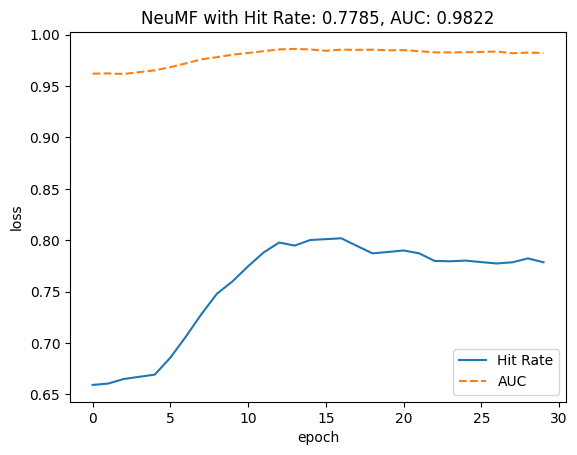

In [12]:
batch_size = 1024
df, num_users, num_items, item_original = read_data()
train_data, test_data = split_data(df, 0.25)
users_train, items_train, ratings_train, candidates = load_data(train_data, num_users, num_items, feedback="explicit")
users_test, items_test, ratings_test, test_iter = load_data(test_data, num_users, num_items, feedback="explicit")
train_dataset = PRDataset(users_train, items_train, candidates, num_items)
train_iter = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=os.cpu_count(), 
)

net = NeuMF(num_factors= 2048, num_users=num_users, num_items=num_items, nums_hiddens=[2048, 1024, 512, 256, 128, 64, 32, 16])
print(net)
net = net.to(device)

lr = 5e-3
num_epochs = 30
weight_decay = 1e-4 #5e-5
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

class BPRLoss(nn.Module):
    def __init__(self):
        super(BPRLoss, self).__init__()

    def forward(self, pos_preds, neg_preds):
        return -torch.mean(torch.log(torch.sigmoid(pos_preds - neg_preds)))

loss_fn = BPRLoss()

top_k = 5
hit, auc, loss = train_ranking(
    net=net,
    train_iter=train_iter,
    test_iter=test_iter,
    loss_fn=loss_fn,
    optimizer=optimizer,
    test_seq_iter=None,
    num_users=num_users,
    num_items=num_items,
    num_epochs=num_epochs,
    device=device,
    candidates=candidates,
    batch_size=batch_size,
    top_k=top_k,
    evaluator=evaluate_ranking,
)

plt.plot(hit)
plt.plot(auc, '--')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title(f'NeuMF with Hit Rate: {hit[-1]:.4f}, AUC: {auc[-1]:.4f}')
plt.legend(['Hit Rate', 'AUC'])

In [13]:
print(f'Hit Rate@{top_k} is {hit[-1]:.3f} AUC is {auc[-1]:.3f}')

Hit Rate@5 is 0.778 AUC is 0.982


In [14]:
def show_random_prediction(user, net, test_data, num_users, num_items, candidates, top_k, device):
    net.eval()
    random_user = user 
    print(f"Random User: {random_user}")
    user_candidates = list(set(range(num_items)) - set(candidates[random_user]))
    if len(user_candidates) == 0:
        print("No candidates available for this user.")
        return
        
    print(f"Number of candidates: {len(user_candidates)}")
    user_ids = [random_user] * len(user_candidates)
    item_ids = user_candidates
    try:
        user_tensor = torch.tensor(user_ids, device=device)
        item_tensor = torch.tensor(item_ids, device=device)
    except Exception as e:
        print(f"Error constructing tensors: {e}")
        return
    with torch.no_grad():
        scores = net(user_tensor, item_tensor).cpu().numpy()
    ranked_items = sorted(zip(user_candidates, scores), key=lambda x: x[1], reverse=True)
    print(f"User {random_user}'s Top-{top_k} Recommendations (Original Labels):")
    for rank, (item, score) in enumerate(ranked_items[:top_k], start=1):
        original_label = item_original[item]
        print(f"Rank {rank}: Item {original_label} with score {float(score):.4f}")

        
show_random_prediction(
    user=100,
    net=net,
    test_data=test_data,
    num_users=num_users,
    num_items=num_items,
    candidates=candidates,
    top_k=top_k,
    device=device
)

Random User: 100
Number of candidates: 26
User 100's Top-5 Recommendations (Original Labels):
Rank 1: Item P3 with score 0.0503
Rank 2: Item T7 with score -0.4118
Rank 3: Item P5 with score -0.7102
Rank 4: Item T15 with score -0.7236
Rank 5: Item S2 with score -1.0723


/tmp/ipykernel_30/3535292676.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Rank {rank}: Item {original_label} with score {float(score):.4f}")


User     0
Item     0
Score    0
dtype: int64
FOLD 1


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1, Hit Rate: 0.661, AUC: 0.962 Training Loss: 0.730
Epoch 2, Hit Rate: 0.668, AUC: 0.963 Training Loss: 0.665
Epoch 3, Hit Rate: 0.667, AUC: 0.964 Training Loss: 0.624
Epoch 4, Hit Rate: 0.671, AUC: 0.965 Training Loss: 0.582
Epoch 5, Hit Rate: 0.676, AUC: 0.966 Training Loss: 0.525
Epoch 6, Hit Rate: 0.690, AUC: 0.968 Training Loss: 0.466
Epoch 7, Hit Rate: 0.704, AUC: 0.971 Training Loss: 0.408
Epoch 8, Hit Rate: 0.731, AUC: 0.974 Training Loss: 0.356
Epoch 9, Hit Rate: 0.750, AUC: 0.977 Training Loss: 0.317
Epoch 10, Hit Rate: 0.760, AUC: 0.978 Training Loss: 0.288
Epoch 11, Hit Rate: 0.772, AUC: 0.981 Training Loss: 0.265
Epoch 12, Hit Rate: 0.787, AUC: 0.981 Training Loss: 0.247
Epoch 13, Hit Rate: 0.793, AUC: 0.984 Training Loss: 0.229
Epoch 14, Hit Rate: 0.795, AUC: 0.985 Training Loss: 0.212
Epoch 15, Hit Rate: 0.792, AUC: 0.984 Training Loss: 0.194
Epoch 16, Hit Rate: 0.793, AUC: 0.983 Training Loss: 0.176
Epoch 17, Hit Rate: 0.789, AUC: 0.983 Training Loss: 0.158
Epoch 

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1, Hit Rate: 0.663, AUC: 0.963 Training Loss: 0.732
Epoch 2, Hit Rate: 0.664, AUC: 0.964 Training Loss: 0.662
Epoch 3, Hit Rate: 0.669, AUC: 0.966 Training Loss: 0.622
Epoch 4, Hit Rate: 0.675, AUC: 0.964 Training Loss: 0.576
Epoch 5, Hit Rate: 0.677, AUC: 0.966 Training Loss: 0.525
Epoch 6, Hit Rate: 0.692, AUC: 0.968 Training Loss: 0.466
Epoch 7, Hit Rate: 0.710, AUC: 0.970 Training Loss: 0.410
Epoch 8, Hit Rate: 0.731, AUC: 0.975 Training Loss: 0.360
Epoch 9, Hit Rate: 0.742, AUC: 0.975 Training Loss: 0.320
Epoch 10, Hit Rate: 0.764, AUC: 0.978 Training Loss: 0.290
Epoch 11, Hit Rate: 0.775, AUC: 0.980 Training Loss: 0.267
Epoch 12, Hit Rate: 0.791, AUC: 0.983 Training Loss: 0.247
Epoch 13, Hit Rate: 0.799, AUC: 0.983 Training Loss: 0.228
Epoch 14, Hit Rate: 0.797, AUC: 0.983 Training Loss: 0.210
Epoch 15, Hit Rate: 0.805, AUC: 0.985 Training Loss: 0.190
Epoch 16, Hit Rate: 0.798, AUC: 0.985 Training Loss: 0.173
Epoch 17, Hit Rate: 0.798, AUC: 0.983 Training Loss: 0.155
Epoch 

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1, Hit Rate: 0.664, AUC: 0.965 Training Loss: 0.731
Epoch 2, Hit Rate: 0.655, AUC: 0.963 Training Loss: 0.665
Epoch 3, Hit Rate: 0.664, AUC: 0.963 Training Loss: 0.624
Epoch 4, Hit Rate: 0.667, AUC: 0.962 Training Loss: 0.580
Epoch 5, Hit Rate: 0.673, AUC: 0.966 Training Loss: 0.523
Epoch 6, Hit Rate: 0.679, AUC: 0.968 Training Loss: 0.467
Epoch 7, Hit Rate: 0.701, AUC: 0.973 Training Loss: 0.408
Epoch 8, Hit Rate: 0.718, AUC: 0.974 Training Loss: 0.358
Epoch 9, Hit Rate: 0.743, AUC: 0.978 Training Loss: 0.319
Epoch 10, Hit Rate: 0.768, AUC: 0.980 Training Loss: 0.288
Epoch 11, Hit Rate: 0.775, AUC: 0.982 Training Loss: 0.265
Epoch 12, Hit Rate: 0.792, AUC: 0.984 Training Loss: 0.245
Epoch 13, Hit Rate: 0.789, AUC: 0.984 Training Loss: 0.227
Epoch 14, Hit Rate: 0.794, AUC: 0.984 Training Loss: 0.207
Epoch 15, Hit Rate: 0.785, AUC: 0.985 Training Loss: 0.189
Epoch 16, Hit Rate: 0.786, AUC: 0.982 Training Loss: 0.171
Epoch 17, Hit Rate: 0.789, AUC: 0.982 Training Loss: 0.152
Epoch 

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1, Hit Rate: 0.659, AUC: 0.963 Training Loss: 0.731
Epoch 2, Hit Rate: 0.659, AUC: 0.963 Training Loss: 0.664
Epoch 3, Hit Rate: 0.657, AUC: 0.962 Training Loss: 0.627
Epoch 4, Hit Rate: 0.661, AUC: 0.963 Training Loss: 0.580
Epoch 5, Hit Rate: 0.676, AUC: 0.964 Training Loss: 0.523
Epoch 6, Hit Rate: 0.690, AUC: 0.970 Training Loss: 0.465
Epoch 7, Hit Rate: 0.711, AUC: 0.972 Training Loss: 0.406
Epoch 8, Hit Rate: 0.737, AUC: 0.975 Training Loss: 0.356
Epoch 9, Hit Rate: 0.753, AUC: 0.978 Training Loss: 0.318
Epoch 10, Hit Rate: 0.772, AUC: 0.979 Training Loss: 0.289
Epoch 11, Hit Rate: 0.786, AUC: 0.983 Training Loss: 0.265
Epoch 12, Hit Rate: 0.796, AUC: 0.983 Training Loss: 0.246
Epoch 13, Hit Rate: 0.797, AUC: 0.985 Training Loss: 0.229
Epoch 14, Hit Rate: 0.804, AUC: 0.986 Training Loss: 0.211
Epoch 15, Hit Rate: 0.802, AUC: 0.985 Training Loss: 0.192
Epoch 16, Hit Rate: 0.804, AUC: 0.987 Training Loss: 0.173
Epoch 17, Hit Rate: 0.800, AUC: 0.985 Training Loss: 0.155
Epoch 

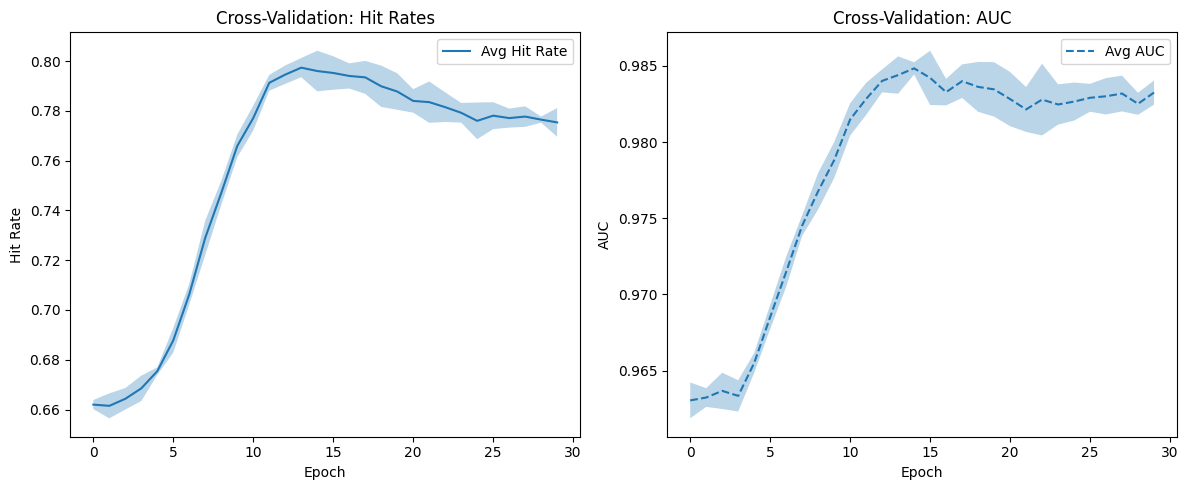

Cross-Validation Summary:
Final Hit Rate: 0.7754 ± 0.0058
Final AUC: 0.9833 ± 0.0008


In [15]:
def k_fold_cross_validation_recommender(df, num_users, num_items):
    kfold = KFold(n_splits=4, shuffle=True, random_state=42) 
    fold_results = {
        'hit_rates': [],
        'aucs': [],
        'losses': []
    }
    for fold, (train_index, test_index) in enumerate(kfold.split(df), 1):
        print(f"FOLD {fold}") 
        
        train_data = df.iloc[train_index]
        val_data = df.iloc[test_index]
        users_train, items_train, ratings_train, candidates = load_data(train_data, num_users, num_items, feedback="explicit")
        users_val, items_val, ratings_val, val_iter = load_data(val_data, num_users, num_items, feedback="explicit")
        train_dataset = PRDataset(users_train, items_train, candidates, num_items)
        train_iter = DataLoader(
            train_dataset, 
            batch_size=batch_size, 
            shuffle=True, 
            num_workers=os.cpu_count(), 
        )
        net = NeuMF(num_factors= 2048, num_users=num_users, num_items=num_items, nums_hiddens=[2048, 1024, 512, 256, 128, 64, 32, 16])
        net = net.to(device)
        
        lr = 5e-3
        num_epochs = 20
        weight_decay = 1e-4 #5e-5
        optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
        # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

        class BPRLoss(nn.Module):
            def __init__(self):
                super(BPRLoss, self).__init__()

            def forward(self, pos_preds, neg_preds):
                return -torch.mean(torch.log(torch.sigmoid(pos_preds - neg_preds)))

        loss_fn = BPRLoss()
                
        top_k = 5      
        hit, auc, loss = train_ranking(
            net=net,
            train_iter=train_iter,
            test_iter=val_iter,
            loss_fn=loss_fn,
            optimizer=optimizer,
            test_seq_iter=None,
            num_users=num_users,
            num_items=num_items,
            num_epochs=num_epochs,
            device=device,
            candidates=candidates,
            batch_size=batch_size,
            top_k=top_k,
            evaluator=evaluate_ranking,
        )
        
        fold_results['hit_rates'].append(hit)
        fold_results['aucs'].append(auc)
        fold_results['losses'].append(loss)
    
    return fold_results
    
def analyze_cv_results(fold_results):
    avg_hit_rates = np.mean(fold_results['hit_rates'], axis=0)
    std_hit_rates = np.std(fold_results['hit_rates'], axis=0)
    
    avg_aucs = np.mean(fold_results['aucs'], axis=0)
    std_aucs = np.std(fold_results['aucs'], axis=0)   

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(avg_hit_rates, label='Avg Hit Rate')
    plt.fill_between(
        range(len(avg_hit_rates)), 
        avg_hit_rates - std_hit_rates, 
        avg_hit_rates + std_hit_rates, 
        alpha=0.3
    )
    plt.title('Cross-Validation: Hit Rates')
    plt.xlabel('Epoch')
    plt.ylabel('Hit Rate')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(avg_aucs, label='Avg AUC', linestyle='--')
    plt.fill_between(
        range(len(avg_aucs)), 
        avg_aucs - std_aucs, 
        avg_aucs + std_aucs, 
        alpha=0.3
    )
    plt.title('Cross-Validation: AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    print("Cross-Validation Summary:")
    print(f"Final Hit Rate: {avg_hit_rates[-1]:.4f} ± {std_hit_rates[-1]:.4f}")
    print(f"Final AUC: {avg_aucs[-1]:.4f} ± {std_aucs[-1]:.4f}")

df, num_users, num_items, item_original = read_data()
cv_results = k_fold_cross_validation_recommender(
    df, 
    num_users, 
    num_items, 
)
analyze_cv_results(cv_results)

## END

In [16]:
# def predict_single_item(net, user_id, item_id, device, item_original=None):
#     """Generate prediction for a single user-item pair."""
#     net.eval()
    
#     user_tensor = torch.tensor([user_id], device=device)
#     item_tensor = torch.tensor([item_id], device=device)
    
#     with torch.no_grad():
#         prediction = net(user_tensor, item_tensor)
#         raw_score = float(prediction.cpu().numpy()[0][0])
        
#         # Normalize score to [0,1] range
#         normalized_score = 1 / (1 + np.exp(-raw_score))
    
#     item_name = item_original[item_id] if item_original is not None else None
#     return normalized_score, item_name, raw_score

# def analyze_single_prediction(net, user_id, item_id, candidates, item_original, device):
#     """Analyze and display prediction for a single user-item pair."""
#     user_items = set(candidates[user_id])
#     has_interaction = item_id in user_items
    
#     normalized_score, item_name, raw_score = predict_single_item(
#         net, user_id, item_id, device, item_original
#     )
    
#     print(f"\n{'='*20} Single Item Prediction {'='*20}")
#     print(f"User ID: {user_id}")
#     print(f"Item: {item_name} (ID: {item_id})")
#     print(f"Raw Prediction Score: {raw_score:.4f}")
#     print(f"Normalized Score: {normalized_score:.4f}")
#     print(f"Previous Interaction: {'Yes' if has_interaction else 'No'}")
    
#     return normalized_score, raw_score, has_interaction


In [17]:
# from sklearn.model_selection import KFold
# kfold = KFold(n_splits=5, shuffle=True, random_state=42) 
# for fold, (train_index, test_index) in enumerate(kfold.split(df), 1):
#     print(fold, len(train_index), len(test_index))

In [18]:
# param_grid = {
#     'learning_rate': [0.001, 0.01, 0.1],
#     'hidden_size': [16, 32, 64],
#     'batch_size': [32, 64],
#     'num_epochs': [10, 20]
# }

# grid = ParameterGrid(param_grid)
# results = []
# for params in grid:
#     _, _, loss = train_ranking (
#         net=net,
#         train_iter=train_iter,
#         test_iter=test_iter,
#         loss_fn=loss_fn,
#         optimizer=optimizer,
#         test_seq_iter=None,
#         num_users=num_users,
#         num_items=num_items,
#         num_epochs=num_epochs,
#         device=device,
#         candidates=candidates,
#         batch_size=batch_size,
#         top_k=top_k,
#         evaluator=evaluate_ranking,
#     )
#     results.append((params, loss))
#     print(f"Params: {params}, Loss: {loss:.4f}")

# # Find the best parameters
# best_params = max(results, key=lambda x: x[2])
# print("Best Parameters:", best_params[0])
# print("Best Validation Accuracy:", best_params[2])

In [19]:
# best_params = max(results, key=lambda x: x[1])
# best_params

In [20]:
# def hit_and_auc(rankedlist, test_matrix, k):
#     hits_k = [(idx, val) for idx, val in enumerate(rankedlist[:k])
#               if val in set(test_matrix)]
#     hits_all = [(idx, val) for idx, val in enumerate(rankedlist)
#                 if val in set(test_matrix)]
#     print(f'hits_k {hits_k}')
#     print(f'hits_all {hits_all}')
#     max = len(rankedlist) - 1
#     auc = 1.0 * (max - hits_all[0][0]) / max if len(hits_all) > 0 else 0
#     return len(hits_k) / k, auc
    
    
# ranked_list, ranked_items, hit_rate, auc = {}, {}, [], []
# all_items = set([i for i in range(num_items)])
# for u in range(num_users):
#     neg_items = list(all_items - set(candidates[int(u)]))    
#     user_ids = [u] * len(neg_items)
#     item_ids = neg_items
#     x = [torch.tensor(user_ids, device=device), torch.tensor(item_ids, device=device)]
#     test_data_iter = torch.utils.data.DataLoader(
#         dataset=list(zip(*x)), batch_size=batch_size, shuffle=False
#     )
#     scores = []
#     for batch in test_data_iter:
#         user_batch, item_batch = batch[0].to(device), batch[1].to(device)
#         batch_scores = net(user_batch, item_batch).cpu().detach().numpy()
#         scores.extend(batch_scores)
#     item_scores = list(zip(item_ids, scores))
#     ranked_list[u] = sorted(item_scores, key=lambda t: t[1], reverse=True)
#     ranked_items[u] = [r[0] for r in ranked_list[u]]
#     # print(f'ranked_list {ranked_list}')
#     print(f'ranked_item {ranked_items[u]} len {len(ranked_items[u])}')
#     print(f'test_iter {test_iter[u]}')
#     hit, auc_val = hit_and_auc(ranked_items[u], test_iter[u], 5)
#     print(hit, auc_val)
#     hit_rate.append(hit)
#     auc.append(auc_val)
#     print(hit_rate)
#     print(np.mean(np.array(hit_rate)))
#     break

# ranked_items[u] = [r[0] for r in ranked_list[u]]
# print(ranked_items[u])
# print(test_iter[0])
# list(candidates[0])
# train_data[train_data['User'] == 0]

# hits_k = [(idx, val) for idx, val in enumerate(ranked_items[1][:5])
#               if val in set(test_iter)]
# print(hits_k)
# correct_position_count = 0
# for idx, val in hits_k:
#     print(val)
#     if ranked_items[1][idx] == val:
#         correct_position_count += 1
        
# correct_position_count

# def load_data(data, num_users, num_items, feedback='explicit'):
#     users, items, scores = [], [], []
#     inter = np.zeros((num_users, num_items)) if feedback == 'explicit' else {}
#     for line in data.itertuples():
#         user_index, item_index = int(line[1] - 1), int(line[2] - 1)
#         score = int(line[3]) if feedback == 'explicit' else 1
#         users.append(user_index)
#         items.append(item_index)
#         scores.append(score)
#         if feedback == 'implicit':
#             inter.setdefault(user_index, []).append(item_index)
#         else:
#             inter[user_index, item_index] = score
#     return users, items, scores, inter
    
# users_train, items_train, ratings_train, candidates = load_data(train_data, num_users, num_items, feedback="explicit")
# train_dataset = PRDataset(users_train, items_train, candidates, num_items)
# train_iter = DataLoader(
#     train_dataset, 
#     batch_size=batch_size, 
#     shuffle=True, 
#     num_workers=os.cpu_count(), 
# )


# net = NeuMF(num_factors=10, num_users=num_users, num_items=num_items, nums_hiddens=[32, 16, 4])
# print(net)
# all_items = set([i for i in range(num_items)])
# for u in range(1):
#     x, user_ids, item_ids, scores = [], [], [], []
#     neg_items = list(all_items - set(candidates[int(u)]))    
#     [item_ids.append(i) for i in neg_items]
#     [user_ids.append(u) for _ in neg_items]
#     x.extend([np.array(user_ids)])
#     x.extend([np.array(item_ids)])
#     test_data_iter = torch.utils.data.DataLoader(
#             dataset=list(zip(*x)), batch_size=64, shuffle=False)
#     for batch in test_data_iter:
#         user_batch, item_batch = batch[0].to(device), batch[1].to(device)
#         print(user_batch, item_batch)
#         batch_scores = net(user_batch, item_batch).cpu().detach().numpy()
#         scores.extend(batch_scores)
#     print(scores)
#     break
# for epoch in tqdm(range(num_epochs)):
#     total_loss, num_examples, num_batches = 0.0, 0, 0
#     net.train()
#     for i, values in enumerate(train_iter):
#         print(input_data[0].size(0))
#         input_data = [v.to(device) for v in values]
#         optimizer.zero_grad() 
#         print(input_data[1], input_data[2])
#         p_pos = net(input_data[0], input_data[1])  
#         p_neg = net(input_data[0], input_data[2])  
#         loss = loss_fn(p_pos, p_neg)
#         print(loss)
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item() * input_data[0].size(0)
#         print(loss, total_loss)
#         num_examples += input_data[0].size(0)
#         num_batches += 1
#         i += 1
#         if i == 5:
#             break
#     break
test_iter[568]

[18, 20, 30, 32, 9, 3, 17, 38, 8, 11, 14]

In [21]:
candidates[568]

[24,
 7,
 35,
 48,
 19,
 4,
 36,
 10,
 41,
 42,
 46,
 23,
 25,
 43,
 1,
 6,
 40,
 47,
 27,
 50,
 21,
 0,
 5,
 37,
 49,
 34,
 39,
 44,
 2,
 26,
 16,
 31,
 33]